In [1]:
import math

millnames = ['',' tys',' mln',' mld',' tln']
def humanReadable_large(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

In [2]:
from random import randint
import time

dataLength = 10000000;

start = time.time();

x = [randint(1, 5) for p in range(dataLength)];

end = time.time();

print('Czas losowania danych: ' + str(round(end-start, 4)) + 's, ilość danych: ' + humanReadable_large(dataLength));

Czas losowania danych: 10.4135s, ilość danych: 10 mln


### Metoda 1: Klasyczne `sum() / len()`:

In [3]:
start = time.time();

avg = sum(x) / len(x);

end = time.time();

print('Czas: ' + str(round(end-start, 4)) + 's, wartość: ' + str(avg));

Czas: 0.0768s, wartość: 3.0003036


### Metoda 2: Klasyczna średnia:

In [4]:
start = time.time();

amount = 0;
for item in x:
    amount += item;
avg = amount / dataLength;

end = time.time();

print('Czas: ' + str(round(end-start, 4)) + 's, wartość: ' + str(avg));

Czas: 0.7771s, wartość: 3.0003036


### Metoda 3: MapReduce (bez podziału na części + bez wątków):

In [5]:
arr = [];

start = time.time();

for i in set(x):
    arr.append([i, x.count(i)]);

full_sum = 0;
for (i, j) in arr:
    full_sum += (i * j);

avg = full_sum / dataLength;

end = time.time();

print('Czas: ' + str(round(end-start, 4)) + 's, wartość: ' + str(avg));

Czas: 0.7934s, wartość: 3.0003036


### Metoda 4: MapReduce (podział na części + wątki):

In [6]:
def chunkenizer(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [7]:
def map_reduce(lst, results):
    for i in set(lst):   # Mapuj
        if i in results: # Redukuj
            results[i] = results[i] + lst.count(i);
        else:
            results[i] = lst.count(i);

Zawsze: `[value, counter]`

Czas: 0.8667s, wartość: 3.0003036, ilość kawałków (ilość wątków): 1, rozmiar kawałka: 10000000
Czas: 0.8901s, wartość: 3.0003036, ilość kawałków (ilość wątków): 2, rozmiar kawałka: 5000000
Czas: 0.8659s, wartość: 3.0003036, ilość kawałków (ilość wątków): 4, rozmiar kawałka: 2500000
Czas: 0.9137s, wartość: 3.0003036, ilość kawałków (ilość wątków): 5, rozmiar kawałka: 2000000
Czas: 0.9863s, wartość: 3.0003036, ilość kawałków (ilość wątków): 8, rozmiar kawałka: 1250000
Czas: 0.9314s, wartość: 3.0003036, ilość kawałków (ilość wątków): 10, rozmiar kawałka: 1000000
Czas: 0.9653s, wartość: 3.0003036, ilość kawałków (ilość wątków): 16, rozmiar kawałka: 625000
Czas: 0.9387s, wartość: 3.0003036, ilość kawałków (ilość wątków): 20, rozmiar kawałka: 500000
Czas: 1.0208s, wartość: 3.0003036, ilość kawałków (ilość wątków): 25, rozmiar kawałka: 400000
Czas: 0.9393s, wartość: 3.0003036, ilość kawałków (ilość wątków): 32, rozmiar kawałka: 312500
Czas: 0.9306s, wartość: 3.0003036, ilość kawałków (ilość w

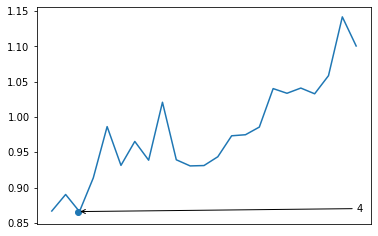

In [12]:
import threading
import multiprocessing
import numpy as np
import sys
import matplotlib.pyplot as plt

chunk_size = dataLength;

best_time = sys.maxsize;
best_chunk_size = sys.maxsize;

to_plot_time = [];
to_plot_chunks = [];

ctr = 0;
best_ctr = sys.maxsize;
while True:
    if (dataLength % chunk_size) == 0:

        chunks = int(dataLength / chunk_size);

        start = time.time();

        splitted = list(chunkenizer(x, chunk_size));
        #splitted = np.array_split(np.array(x), chunks); # Wolne

        results = {};
        for i in splitted:
            tmp = i;
            thread = threading.Thread(target=map_reduce, args=(tmp, results,));
            thread.start();
            thread.join();

        full_sum = 0;
        for key, value in results.items():
            full_sum += int(key) * value;

        avg = full_sum / dataLength;

        end = time.time();
        
        curr_time = end-start;
        
        if curr_time < best_time:
            best_time = curr_time;
            best_chunk_size = chunks;
            best_ctr = ctr;

        print('Czas: ' + str(round(curr_time, 4)) + 's, wartość: ' + str(avg) + ', ilość kawałków (ilość wątków): ' + str(chunks) + ', rozmiar kawałka: ' + str(chunk_size));
        
        to_plot_time.append(curr_time);
        to_plot_chunks.append(chunks);
        ctr += 1;
    
    chunk_size -= 1;
    
    if chunk_size == 16000:
        break;

print('\nNajlepszy czas: ' + str(round(best_time, 4)) + ', dla ilości kawałków: ' + str(best_chunk_size));

frame1 = plt.gca();
frame1.axes.get_xaxis().set_visible(False);

plt.plot(np.linspace(0, ctr, ctr), to_plot_time);
plt.scatter(best_ctr, best_time);
plt.annotate(best_chunk_size, (best_ctr, best_time), xytext=(ctr, best_time), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));

### Metoda 5: Wykorzystanie `statistics.mean()`:

In [8]:
import statistics

start = time.time();

avg = statistics.mean(x);

end = time.time();

print('Czas: ' + str(round(end-start, 4)) + 's, wartość: ' + str(avg));

Czas: 5.3558s, wartość: 3.0003036
